In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Single-run simulation

In [34]:
# processed matrix file(not open to public)
matrix5=np.loadtxt('matrix5.txt',dtype='int')

50581917


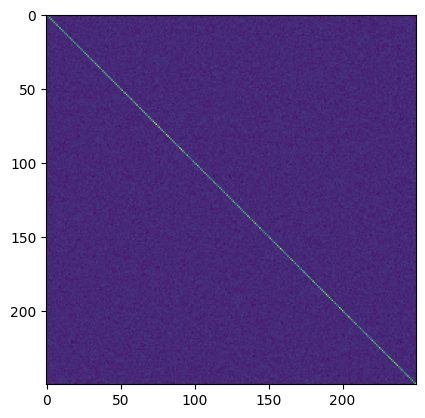

In [36]:
# randomized commuting matrix
matrix5=np.random.normal(800,100,size=(250,250))
matrix5=matrix5.astype('int')
if np.sum(matrix5<0):
  print('negative population')
for i in range(250):
  matrix5[i,i]*=4
plt.imshow(matrix5)
print(np.sum(matrix5))
plt.show()

In [17]:
def initialize(matrix,index,seed=10):
  # creating initial N,S,I,R matrix
  size=len(matrix)
  N=matrix.copy().astype('int')
  S=matrix.copy().astype('int')
  I=np.zeros([size,size],dtype='float')
  R=np.zeros([size,size],dtype='float')
  S[index,index]=S[index,index]-seed
  I[index,index]=I[index,index]+seed
  return N,S,I,R
def day_infection(N,S,I,R,beta,gamma):
  # calculating day infection dynamics
  I_sum=I.sum(axis=1) # number of infected population in workplace
  N_sum=N.sum(axis=1)
  contact=beta*S*I_sum[:,None]
  infected=np.divide(contact,N_sum,out=np.zeros_like(contact),where=N!=0) # equals to S*phi_day
  recovered=gamma*I
  new_S=np.clip(S-infected,0,None)
  new_I=np.clip(I+infected-recovered,0,None)
  new_R=R+recovered
  return np.round(new_S,6),np.round(new_I,6),np.round(new_R,6)
def ngt_infection(N,S,I,R,beta,gamma):
  # calculating day infection dynamics
  I_sum=I.sum(axis=0) # number of infected population in home location
  N_sum=N.sum(axis=0)
  contact=beta*(S.T*I_sum[:,None]).T
  infected=np.divide(contact,N_sum,out=np.zeros_like(contact),where=N!=0)  # equls to S*phi_ngt
  recovered=gamma*I
  new_S=np.clip(S-infected,0,None)
  new_I=np.clip(I+infected-recovered,0,None)
  new_R=R+recovered
  return np.round(new_S,6),np.round(new_I,6),np.round(new_R,6)

In [18]:
def get_Ns(N):
  # calculate N in daytime and nighttime
  # these functions are for simulating daytime mixing and nighttime mixing in SMPM
  Nday=(N.T/N.sum(axis=1)).T #day
  Nngt=N/N.sum(axis=0)  # night
  return Nday,Nngt
def day_mixing(N,S,I,R,Nday):
  # Susceptible, Infected, Recovered population ratios of commuters are same with those at daytime location in SMPM
  new_S=(Nday.T*(S.sum(axis=1))).T
  new_I=(Nday.T*(I.sum(axis=1))).T
  new_R=(Nday.T*(R.sum(axis=1))).T
  return new_S,new_I,new_R
def ngt_mixing(N,S,I,R,Nngt):
  # Susceptible, Infected, Recovered population ratios of commuters are same with those at nighttime location in SMPM
  new_S=Nngt*(S.sum(axis=0))
  new_I=Nngt*(I.sum(axis=0))
  new_R=Nngt*(R.sum(axis=0))
  return new_S,new_I,new_R

In [19]:
def simul_CMPM(matrix,beta,gamma,iteration=240,index=0):
  # CMPM process
  I_matrix=np.zeros([240,250])
  N,S,I,R=initialize(matrix,index=index)
  Nday,Nngt=get_Ns(N)
  for j in range(iteration):
    S,I,R=day_infection(N,S,I,R,beta,gamma)
    S,I,R=ngt_infection(N,S,I,R,beta,gamma)
    I_matrix[j]=(I.sum(axis=0)/N.sum(axis=0))
  return I_matrix

In [21]:
def simul_SMPM(matrix,beta,gamma,iteration=240,index=0):
  # SMPM process
  I_matrix=np.zeros([240,250])
  N,S,I,R=initialize(matrix,index=index)
  Nday,Nngt=get_Ns(N)
  for j in range(iteration):
    S,I,R=day_infection(N,S,I,R,beta,gamma)
    S,I,R=day_mixing(N,S,I,R,Nday)
    S,I,R=ngt_infection(N,S,I,R,beta,gamma)
    S,I,R=ngt_mixing(N,S,I,R,Nngt)
    I_matrix[j]=(I.sum(axis=0)/N.sum(axis=0))
  return I_matrix

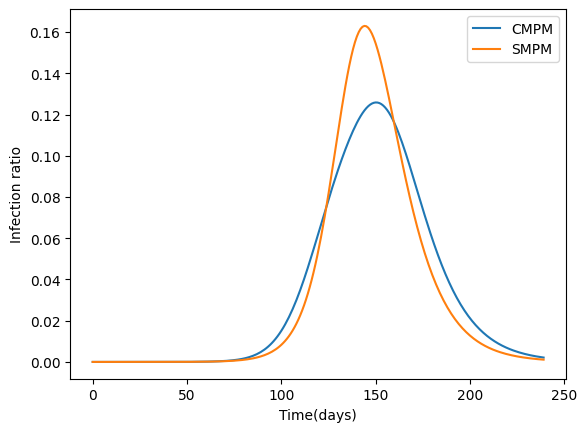

In [35]:
# in the randomly generated commuting matrix, there is no big difference between CMPM and SMPM
# however, in real commuting data, there is a hugh difference.

I_CMPM=simul_CMPM(matrix5,0.1,0.05)
I_SMPM=simul_SMPM(matrix5,0.1,0.05)

plt.plot(I_CMPM.mean(axis=1),label='CMPM')
plt.plot(I_SMPM.mean(axis=1),label='SMPM')
plt.legend()
plt.xlabel('Time(days)')
plt.ylabel('Infection ratio')
plt.show()